In [1]:
import pandas as pd
cols = pd.read_csv("var_names.csv")
data = pd.read_csv('CSCS_data_anon.csv', low_memory=False,
                        na_values=["9999", "", " ", "Presented but no response", "NA"])
empty = (data.isna().sum()==data.shape[0])
data = data[empty.index[~empty]] # keep non empty columns only
data = data[data.REMOVE_case=='No'].copy()

In [2]:
def return_matching_keywords(keywords: list[str]) -> list[str]:
    """
    Returns the names of the columns whos string contains any of the keywords
    """
    global data
    return [col for col in data.columns if any(keyword.lower() in col.lower() for keyword in keywords)]

def get_var_details(var_name: str) -> list[tuple[str, str]]:
    """
    Returns a list of pairs detailing the question and datasets 
    corresponding to the given variable name
    """
    global cols
    filtered_data = cols[cols['new_var'] == var_name]
    
    info = []
    result: pd.DataFrame = filtered_data[['new_var', 'text', 'dataset']]
    for index, row in result.iterrows():
        info.append((row['text'], row['dataset']))

    return info

def get_column_info(column_name: str) -> None:
    """
    Returns information about a given column
    """
    global data, cols
    column_info: pd.DataFrame = data[column_name]
    print(f"{' Information about: ' + column_name + ' ':-^70}")
    details = get_var_details(column_name)
    if not details: print(f"{' No associated question found ':-^70}")
    for question, dataset in details:
        print(f"{' Dataset: ' + dataset + ' ':-^70}")
        print(f"{' Question: ' + question + ' ':-^70}")
        print(f"{'':-^70}\n")
    print(f"Number of NA: {column_info.isna().sum()}")
    print(column_info.value_counts())
    print("")

In [4]:
# Example usage
words = ["home_num"]
to_examine = return_matching_keywords(words)
for col in to_examine:
    get_column_info(col)

---------- Information about: WORK_shift_days_from_home_num ----------
------------------------ Dataset: 2022_cross -------------------------
 Question: On average, how many days per week do you work from home (versus in-person or at an office)? 
----------------------------------------------------------------------

Number of NA: 9605
WORK_shift_days_from_home_num
0.0    124
4.0     57
2.0     57
5.0     55
1.0     43
3.0     38
7.0     29
6.0     10
Name: count, dtype: int64



In [5]:
# Example usage
words = ["burn"]
to_examine = return_matching_keywords(words)
for col in to_examine:
    get_column_info(col)

--- Information about: WELLNESS_malach_pines_burnout_measure_tired ---
------------------------ Dataset: 2021_cross -------------------------
 Question: When you think about your life overall, how often do you feel the following? - Tired 
----------------------------------------------------------------------

------------------------ Dataset: 2022_cohort ------------------------
 Question: When you think about your life overall, how often do you feel the following? - Tired 
----------------------------------------------------------------------

------------------------ Dataset: 2022_cross -------------------------
 Question: When you think about your work overall, how often do you feel the following? - Tired 
----------------------------------------------------------------------

------------------------ Dataset: 2023_cohort ------------------------
 Question: When you think about your life overall, how often do you feel the following? - Tired 
-----------------------------------------

In [7]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

# Filter out rows with NaN in the relevant columns
filtered_data = data[['WORK_shift_days_from_home_num', 'WELLNESS_maslach_burnout_burned_out']].dropna()

# Create a contingency table
contingency_table = pd.crosstab(
    filtered_data['WORK_shift_days_from_home_num'], 
    filtered_data['WELLNESS_maslach_burnout_burned_out']
)

# Perform the Chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Print the results
print(f"Chi-square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Frequencies: \n{expected}")

Chi-square Statistic: 136.11105969738176
P-value: 7.28747856967651e-12
Degrees of Freedom: 42
Expected Frequencies: 
[[13.8238342  11.72020725 28.5492228  11.11917098 20.13471503 20.7357513
   9.91709845]
 [ 4.88601036  4.14248705 10.09067358  3.93005181  7.11658031  7.32901554
   3.50518135]
 [ 6.07772021  5.15284974 12.55181347  4.88860104  8.85233161  9.11658031
   4.36010363]
 [ 4.05181347  3.43523316  8.36787565  3.25906736  5.9015544   6.07772021
   2.90673575]
 [ 6.67357513  5.65803109 13.78238342  5.36787565  9.72020725 10.01036269
   4.78756477]
 [ 6.19689119  5.25388601 12.79792746  4.98445596  9.02590674  9.29533679
   4.44559585]
 [ 1.07253886  0.90932642  2.21502591  0.8626943   1.56217617  1.60880829
   0.76943005]
 [ 3.21761658  2.72797927  6.64507772  2.5880829   4.6865285   4.82642487
   2.30829016]]


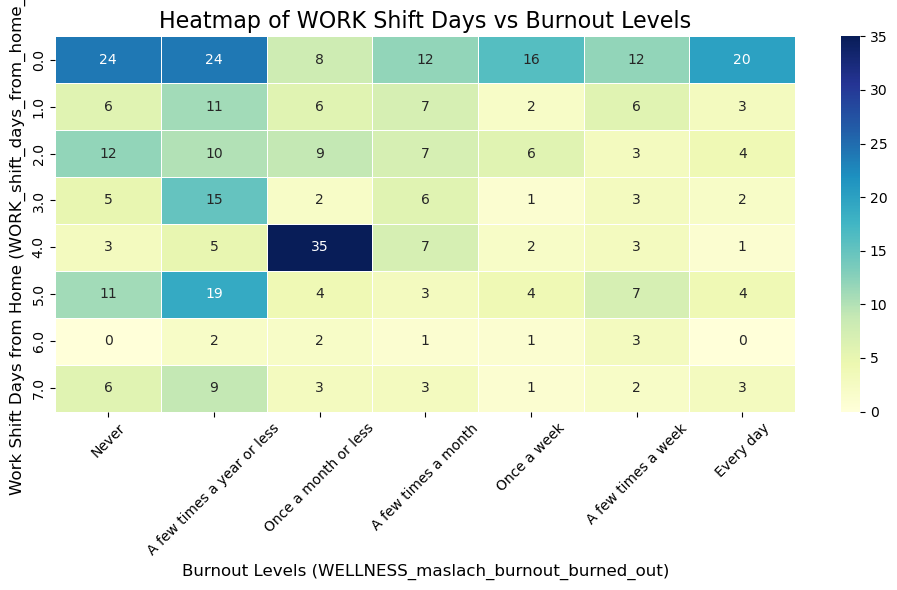

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define the ordered burnout levels (from "Never" to "Every day")
burnout_order = [
    'Never',
    'A few times a year or less',
    'Once a month or less',
    'A few times a month',
    'Once a week',
    'A few times a week',
    'Every day'
]

# Reorder the columns in the contingency table to match the burnout order
contingency_table = pd.crosstab(filtered_data['WORK_shift_days_from_home_num'], filtered_data['WELLNESS_maslach_burnout_burned_out'])

# Reorder columns based on burnout_order
contingency_table = contingency_table[burnout_order]

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    contingency_table,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    cbar=True,
    linewidths=.5
)
plt.title("Heatmap of WORK Shift Days vs Burnout Levels", fontsize=16)
plt.xlabel("Burnout Levels (WELLNESS_maslach_burnout_burned_out)", fontsize=12)
plt.ylabel("Work Shift Days from Home (WORK_shift_days_from_home_num)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


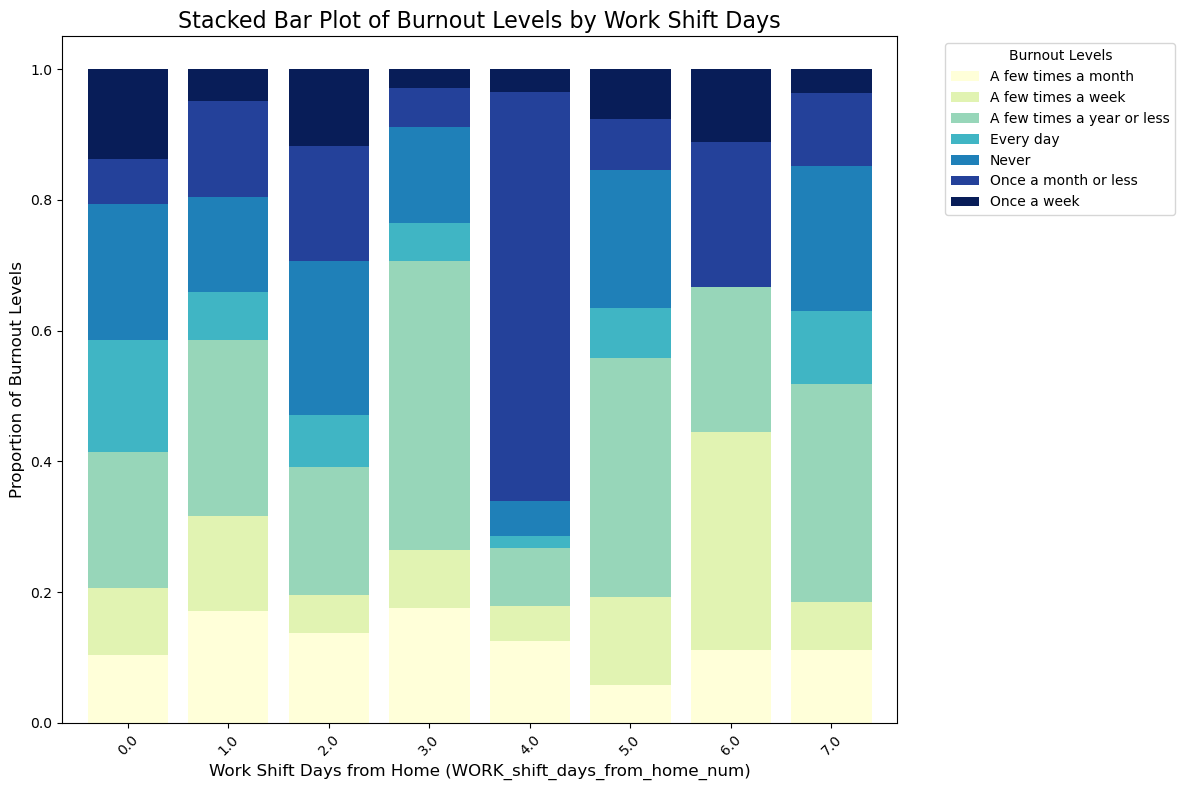

In [9]:
# Calculate proportions for each `WORK_shift_days_from_home_num`
proportions = filtered_data.groupby(
    ['WORK_shift_days_from_home_num', 'WELLNESS_maslach_burnout_burned_out']
).size().unstack().fillna(0)

# Normalize the data to get proportions (each row sums to 1)
proportions = proportions.div(proportions.sum(axis=1), axis=0)

# Plot the stacked bar chart
proportions.plot(kind='bar', stacked=True, figsize=(12, 8), colormap="YlGnBu", width=0.8)

plt.title("Stacked Bar Plot of Burnout Levels by Work Shift Days", fontsize=16)
plt.xlabel("Work Shift Days from Home (WORK_shift_days_from_home_num)", fontsize=12)
plt.ylabel("Proportion of Burnout Levels", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Burnout Levels", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [20]:
import pandas as pd
import statsmodels.api as sm

# Assuming `data` is already filtered for the relevant columns
filtered_data = data[['WORK_shift_days_from_home_num', 'WELLNESS_maslach_burnout_burned_out']].dropna()

# Create the 'work_from_home' binary variable (1 if >1 day, 0 if <=1 day)
filtered_data['work_from_home'] = (filtered_data['WORK_shift_days_from_home_num'] > 1).astype(int)

# Convert 'WELLNESS_maslach_burnout_burned_out' to numeric values
burnout_map = {
    'Never': 0,
    'A few times a year or less': 1,
    'Once a month or less': 2,
    'A few times a month': 3,
    'Once a week': 4,
    'A few times a week': 5,
    'Every day': 6
}

filtered_data['burnout_numeric'] = filtered_data['WELLNESS_maslach_burnout_burned_out'].map(burnout_map)

# Define the independent variable (work_from_home) and the dependent variable (burnout_numeric)
X = sm.add_constant(filtered_data['work_from_home'])  # Add intercept
y = filtered_data['burnout_numeric']

# Fit the linear regression model
linear_model = sm.OLS(y, X)
result = linear_model.fit()

# Output the results
print(result.summary())


                            OLS Regression Results                            
Dep. Variable:        burnout_numeric   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     6.157
Date:                Sun, 17 Nov 2024   Prob (F-statistic):             0.0135
Time:                        23:07:29   Log-Likelihood:                -797.02
No. Observations:                 386   AIC:                             1598.
Df Residuals:                     384   BIC:                             1606.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.6752      0.153     17.

/tmp/ipykernel_71/3194973048.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_71/3194973048.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


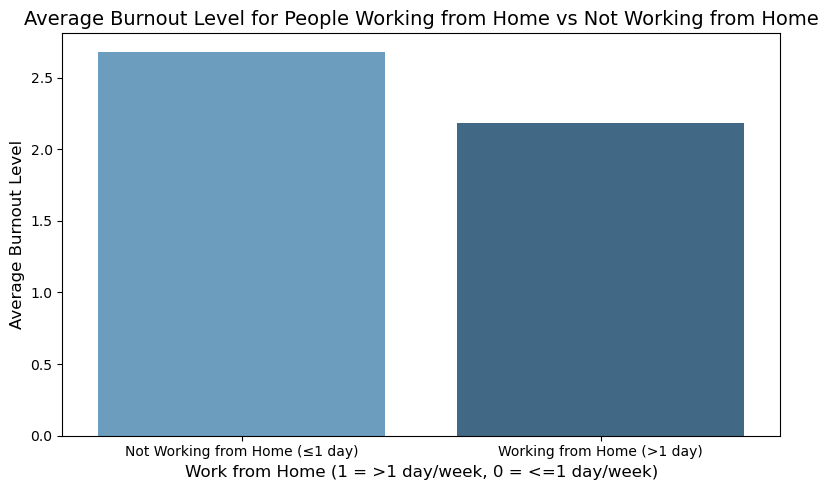

In [22]:
# Plotting the bar plot of mean burnout level for work_from_home vs not
plt.figure(figsize=(8, 5))
sns.barplot(
    x='work_from_home',
    y='burnout_numeric',
    data=filtered_data,
    palette='Blues_d',
    ci=None  # No confidence interval to keep it clean
)

# Set labels and title
plt.xlabel('Work from Home (1 = >1 day/week, 0 = <=1 day/week)', fontsize=12)
plt.ylabel('Average Burnout Level', fontsize=12)
plt.title('Average Burnout Level for People Working from Home vs Not Working from Home', fontsize=14)
plt.xticks([0, 1], ['Not Working from Home (≤1 day)', 'Working from Home (>1 day)'], rotation=0)

# Show the plot
plt.tight_layout()
plt.show()

/tmp/ipykernel_71/2342127208.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  barplot = sns.barplot(
/tmp/ipykernel_71/2342127208.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


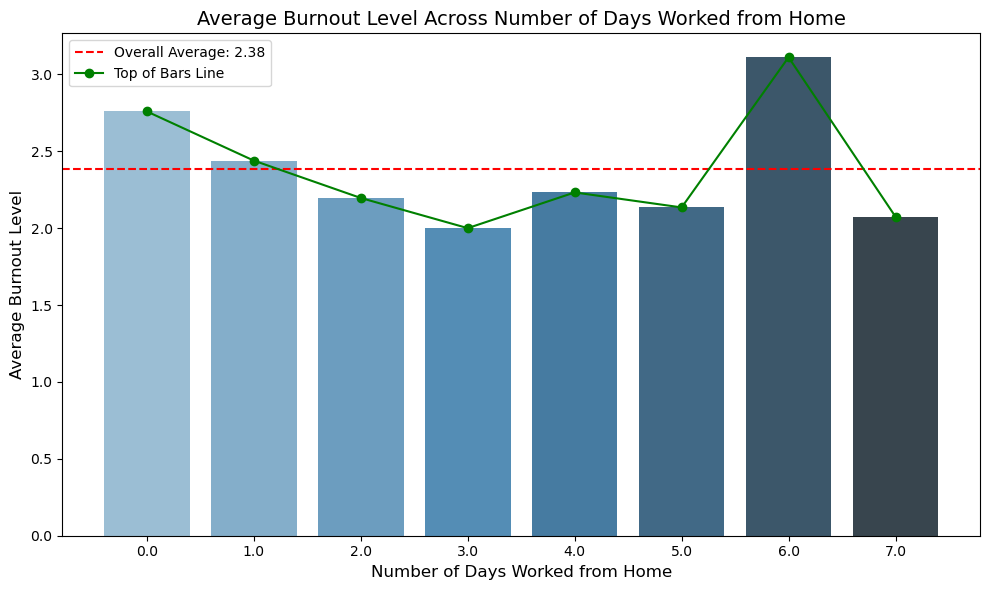

In [28]:
# Apply the mapping to create a numeric burnout variable
filtered_data['burnout_numeric'] = filtered_data['WELLNESS_maslach_burnout_burned_out'].map(burnout_map)

# Calculate the overall average burnout level for the line
overall_average_burnout = filtered_data['burnout_numeric'].mean()

# Plotting the bar plot of average burnout level across different work shift days from home
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    x='WORK_shift_days_from_home_num', 
    y='burnout_numeric', 
    data=filtered_data,
    palette='Blues_d', 
    ci=None  # No confidence interval to keep it clean
)

# Add a horizontal line for the overall average burnout level
plt.axhline(overall_average_burnout, color='red', linestyle='--', label=f'Overall Average: {overall_average_burnout:.2f}')

# Get the top of each bar (height of the bars)
bar_heights = barplot.patches
bar_centers = [bar.get_x() + bar.get_width() / 2 for bar in bar_heights]  # x positions of the bars

# Extract the height of each bar (the average burnout level for each work shift day)
bar_values = [bar.get_height() for bar in bar_heights]

# Plot the line through the tops of the bars
plt.plot(bar_centers, bar_values, color='green', marker='o', linestyle='-', label='Top of Bars Line')

# Set labels and title with more intuitive x-axis label
plt.xlabel('Number of Days Worked from Home', fontsize=12)
plt.ylabel('Average Burnout Level', fontsize=12)
plt.title('Average Burnout Level Across Number of Days Worked from Home', fontsize=14)

# Add a legend to label the lines
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [31]:
data['WORK_shift_days_from_home_num'].value_counts()

WORK_shift_days_from_home_num
0.0    124
4.0     57
2.0     57
5.0     55
1.0     43
3.0     38
7.0     29
6.0     10
Name: count, dtype: int64

# IMPORTANT!

## Days 6 and 7 have relatively low sample sizes and aren't very representative since people working 6-7 days a week will be burnt out anyway. In an effort to reduce outliers, the below code just reproduces everything you've seen above, but only with Days 0-5.

Chi-square Statistic: 123.92812656123566
P-value: 2.2264770835596663e-13
Degrees of Freedom: 30
Expected Frequencies: 
[[20.21714286 27.84       21.21142857 13.92       10.27428571 11.26857143
  11.26857143]
 [ 7.14571429  9.84        7.49714286  4.92        3.63142857  3.98285714
   3.98285714]
 [ 8.88857143 12.24        9.32571429  6.12        4.51714286  4.95428571
   4.95428571]
 [ 5.92571429  8.16        6.21714286  4.08        3.01142857  3.30285714
   3.30285714]
 [ 9.76       13.44       10.24        6.72        4.96        5.44
   5.44      ]
 [ 9.06285714 12.48        9.50857143  6.24        4.60571429  5.05142857
   5.05142857]]
                            OLS Regression Results                            
Dep. Variable:        burnout_numeric   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     5.583
Date:                Mon, 18 Nov 202

/tmp/ipykernel_71/3088073530.py:54: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_71/3088073530.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


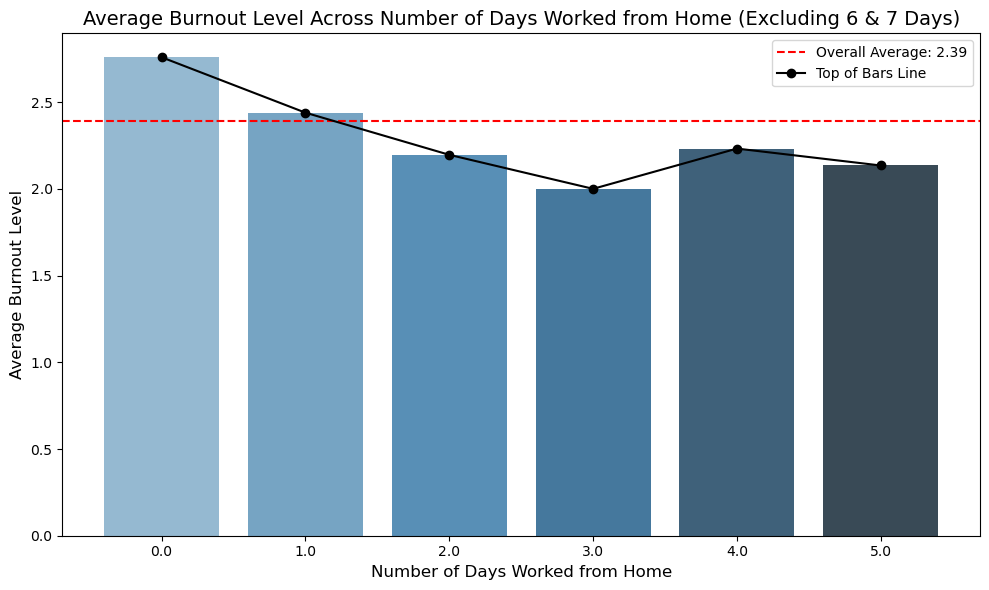

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

# Assuming `filtered_data` is the DataFrame containing the relevant data

# Exclude responses where WORK_shift_days_from_home_num is 6 or 7
filtered_data = filtered_data[~filtered_data['WORK_shift_days_from_home_num'].isin([6, 7])]

# Map burnout levels to numeric values
burnout_map = {
    'Never': 0,
    'A few times a year or less': 1,
    'Once a month or less': 2,
    'A few times a month': 3,
    'Once a week': 4,
    'A few times a week': 5,
    'Every day': 6
}

# Apply the mapping to create a numeric burnout variable
filtered_data['burnout_numeric'] = filtered_data['WELLNESS_maslach_burnout_burned_out'].map(burnout_map)

### Chi-Square Test ###

# Create a contingency table for the chi-square test
contingency_table = pd.crosstab(filtered_data['WORK_shift_days_from_home_num'], filtered_data['burnout_numeric'])

# Perform the Chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Print the result
print(f"Chi-square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Frequencies: \n{expected}")

### OLS Regression ###

# Perform OLS regression (work from home as indicator variable, burnout as numeric)
X = filtered_data['WORK_shift_days_from_home_num']
X = sm.add_constant(X)  # Add a constant for the intercept
y = filtered_data['burnout_numeric']

model = sm.OLS(y, X).fit()
print(model.summary())

### Visualization ###

# Plotting the bar plot of average burnout level across different work shift days from home
plt.figure(figsize=(10, 6))
sns.barplot(
    x='WORK_shift_days_from_home_num', 
    y='burnout_numeric', 
    data=filtered_data,
    palette='Blues_d', 
    ci=None  # No confidence interval to keep it clean
)

# Add a horizontal line for the overall average burnout level
overall_average_burnout = filtered_data['burnout_numeric'].mean()
plt.axhline(overall_average_burnout, color='red', linestyle='--', label=f'Overall Average: {overall_average_burnout:.2f}')

# Get the top of each bar (height of the bars)
bar_heights = plt.gca().patches
bar_centers = [bar.get_x() + bar.get_width() / 2 for bar in bar_heights]  # x positions of the bars

# Extract the height of each bar (the average burnout level for each work shift day)
bar_values = [bar.get_height() for bar in bar_heights]

# Plot the line through the tops of the bars
plt.plot(bar_centers, bar_values, color='black', marker='o', linestyle='-', label='Top of Bars Line')

# Set labels and title
plt.xlabel('Number of Days Worked from Home', fontsize=12)
plt.ylabel('Average Burnout Level', fontsize=12)
plt.title('Average Burnout Level Across Number of Days Worked from Home (Excluding 6 & 7 Days)', fontsize=14)

# Add a legend to label the lines
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
